In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras 
import pandas as pd 
import h5py 
import warnings
warnings.simplefilter("ignore") 
import seaborn as sns
import random 
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input as preprocess_input_vgg
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input as preprocess_input_resnet
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.models import load_model
from glob import glob
import glob

%matplotlib inline 
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'  

In [2]:
os.chdir('/kaggle/input/chest-xray-pneumonia/chest_xray/')  

In [3]:
# Total Number of images during trainings datasets

count_norm_train = 0
for file in glob.glob('train/NORMAL/*.jpeg'):
    count_norm_train = count_norm_train + 1
print("Total number of Normal X-ray scan images are {0}".format(count_norm_train))

count_pneu_train = 0
for file in glob.glob('train/PNEUMONIA/*.jpeg'):
    count_pneu_train = count_pneu_train + 1
print("Total number of Pneumonia X-ray scan images are {0}".format(count_pneu_train))

print("Total number of images in training datasets are {0}".format(count_norm_train+count_pneu_train)) 

Total number of Normal X-ray scan images are 1341
Total number of Pneumonia X-ray scan images are 3875
Total number of images in training datasets are 5216


In [4]:
# Total Number of images in testings datasets

count_norm_test = 0
for file in glob.glob('test/NORMAL/*.jpeg'):
    count_norm_test = count_norm_test + 1
print("Total number of Normal X-ray scan images are {0}".format(count_norm_test))

count_pneu_test = 0
for file in glob.glob('test/PNEUMONIA/*.jpeg'):
    count_pneu_test = count_pneu_test + 1
print("Total number of Pneumonia X-ray scan images are {0}".format(count_pneu_test))

print("Total number of images in testing datasets are {0}".format(count_norm_test+count_pneu_test)) 

Total number of Normal X-ray scan images are 234
Total number of Pneumonia X-ray scan images are 390
Total number of images in testing datasets are 624


(224, 224, 3)


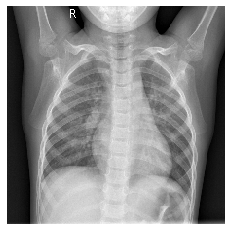

In [5]:
img_size_1 = 224 
imag = cv2.imread('train/NORMAL/IM-0115-0001.jpeg') #, cv2.IMREAD_GRAYSCALE)
imag = cv2.resize(imag, (img_size_1, img_size_1))
print(imag.shape)
plt.imshow(imag)
plt.axis('off')
plt.show()  

In [6]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) 

In [7]:
#class_weight_dict = {0: 0.8380462724935732, 1: 1.2395437262357414}

# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'train'
valid_path = 'test'

In [8]:

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = False)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

test_set = test_datagen.flow_from_directory('test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical') 

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


***Transfer Learning using VGG16***

In [9]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False 

58892288/58889256 [==============================] - 2s 0us/step


In [10]:
# our layers - you can add more if you want
x = Flatten()(vgg.output)

# x = Dense(1000, activation='relu')(x)
prediction_vgg = Dense(2, activation='softmax')(x)

# create a model object
model_vgg16 = Model(inputs=vgg.input, outputs=prediction_vgg)

# view the structure of the model
model_vgg16.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [11]:
# tell the model what cost and optimization method to use
model_vgg16.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy', f1_m, recall_m, precision_m]
) 

In [12]:
# fit the model
r = model_vgg16.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=3,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)  

Epoch 1/3
163/163 [==============================] - 130s 797ms/step - loss: 0.2044 - accuracy: 0.9243 - f1_m: 0.9243 - recall_m: 0.9243 - precision_m: 0.9243 - val_loss: 0.2864 - val_accuracy: 0.9151 - val_f1_m: 0.9141 - val_recall_m: 0.9141 - val_precision_m: 0.9141
Epoch 2/3
163/163 [==============================] - 116s 713ms/step - loss: 0.1002 - accuracy: 0.9613 - f1_m: 0.9613 - recall_m: 0.9613 - precision_m: 0.9613 - val_loss: 0.2240 - val_accuracy: 0.9183 - val_f1_m: 0.9203 - val_recall_m: 0.9203 - val_precision_m: 0.9203
Epoch 3/3
163/163 [==============================] - 118s 724ms/step - loss: 0.0792 - accuracy: 0.9722 - f1_m: 0.9722 - recall_m: 0.9722 - precision_m: 0.9722 - val_loss: 0.2400 - val_accuracy: 0.9135 - val_f1_m: 0.9125 - val_recall_m: 0.9125 - val_precision_m: 0.9125


In [14]:
model_vgg16.save("/kaggle/working/model_vgg16.h5") 

Transfer Learning Using ResNet50

In [15]:
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# don't train existing weights
for layer in resnet.layers:
  layer.trainable = False 

94773248/94765736 [==============================] - 4s 0us/step


In [16]:
y = Flatten()(resnet.output)

prediction_resnet = Dense(2, activation='softmax')(y)

model_resnet = Model(inputs = resnet.input, outputs = prediction_resnet)

In [17]:
model_resnet.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy', f1_m, recall_m, precision_m]
) 

In [18]:
# fit the model
w = model_resnet.fit_generator(
  training_set,
  validation_data=test_set,
  epochs=3,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)  

Epoch 1/3
163/163 [==============================] - 116s 713ms/step - loss: 0.7082 - accuracy: 0.7765 - f1_m: 0.7765 - recall_m: 0.7765 - precision_m: 0.7765 - val_loss: 0.4718 - val_accuracy: 0.7724 - val_f1_m: 0.7766 - val_recall_m: 0.7766 - val_precision_m: 0.7766
Epoch 2/3
163/163 [==============================] - 116s 713ms/step - loss: 0.3107 - accuracy: 0.8681 - f1_m: 0.8681 - recall_m: 0.8681 - precision_m: 0.8681 - val_loss: 0.7800 - val_accuracy: 0.6939 - val_f1_m: 0.6906 - val_recall_m: 0.6906 - val_precision_m: 0.6906
Epoch 3/3
163/163 [==============================] - 118s 724ms/step - loss: 0.2938 - accuracy: 0.8762 - f1_m: 0.8762 - recall_m: 0.8762 - precision_m: 0.8762 - val_loss: 0.4532 - val_accuracy: 0.8109 - val_f1_m: 0.8141 - val_recall_m: 0.8141 - val_precision_m: 0.8141


In [19]:
model_resnet.save("/kaggle/working/model_resnet.h5")

In [24]:
os.chdir('/kaggle/input/chest-xray-pneumonia/chest_xray/val/NORMAL') 
i = 1
for file in os.listdir(os.getcwd()):
    img = image.load_img(file, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    img_data_vgg = preprocess_input_vgg(x)
    classes_vgg_op = model_vgg16.predict(img_data_vgg)
    print("Predication on vgg transfer learning model for validation example {0}".format(i))
    print(classes_vgg_op) 
    
    img_data_resnet = preprocess_input_resnet(x)
    classes_resnet_op = model_resnet.predict(img_data_resnet)
    print("Predication on resnet transfer learning model for validation example {0}".format(i))
    print(classes_resnet_op)
    i = i + 1

Predication on vgg transfer learning model for example 1
[[1.0000000e+00 1.6413974e-38]]
Predication on resnet transfer learning model for example 1
[[1.00000e+00 2.35805e-09]]
Predication on vgg transfer learning model for example 2
[[1.4979424e-27 1.0000000e+00]]
Predication on resnet transfer learning model for example 2
[[0.68971235 0.31028762]]
Predication on vgg transfer learning model for example 3
[[1.0000000e+00 6.6651693e-32]]
Predication on resnet transfer learning model for example 3
[[1.000000e+00 1.953523e-10]]
Predication on vgg transfer learning model for example 4
[[1.000000e+00 9.521988e-25]]
Predication on resnet transfer learning model for example 4
[[9.9999988e-01 1.3590756e-07]]
Predication on vgg transfer learning model for example 5
[[0. 1.]]
Predication on resnet transfer learning model for example 5
[[9.9990475e-01 9.5212505e-05]]
Predication on vgg transfer learning model for example 6
[[0. 1.]]
Predication on resnet transfer learning model for example 6
[[0.

In [25]:
os.chdir('/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA')  
for file in os.listdir(os.getcwd()):
    img = image.load_img(file, target_size=(224,224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    img_data_vgg = preprocess_input_vgg(x)
    classes_vgg_op = model_vgg16.predict(img_data_vgg)
    print("Predication on vgg transfer learning model for validation example {0}".format(i))
    print(classes_vgg_op) 
    
    img_data_resnet = preprocess_input_resnet(x)
    classes_resnet_op = model_resnet.predict(img_data_resnet)
    print("Predication on resnet transfer learning model for validation example {0}".format(i))
    print(classes_resnet_op)
    i = i + 1 

Predication on vgg transfer learning model for validation example 9
[[0. 1.]]
Predication on resnet transfer learning model for validation example 9
[[4.265085e-07 9.999995e-01]]
Predication on vgg transfer learning model for validation example 10
[[0. 1.]]
Predication on resnet transfer learning model for validation example 10
[[8.9480395e-08 9.9999988e-01]]
Predication on vgg transfer learning model for validation example 11
[[0. 1.]]
Predication on resnet transfer learning model for validation example 11
[[9.9993753e-01 6.2489627e-05]]
Predication on vgg transfer learning model for validation example 12
[[0. 1.]]
Predication on resnet transfer learning model for validation example 12
[[9.9959415e-01 4.0584488e-04]]
Predication on vgg transfer learning model for validation example 13
[[0. 1.]]
Predication on resnet transfer learning model for validation example 13
[[9.9954396e-01 4.5596785e-04]]
Predication on vgg transfer learning model for validation example 14
[[1.0000000e+00 2.16

In [ ]:
os.chdir('/kaggle/input/chest-xray-pneumonia/chest_xray/')   

In [21]:
training_set.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}